In [3956]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from scipy.constants import N_A
from scipy import linalg
import math, cmath


In [3957]:
tumour_cell_radius = 8e-6
math.pi*((12.5e-9)**2)/(4*math.pi*((tumour_cell_radius)**2))

6.103515624999999e-07

In [3958]:
Target_cell_number = 2e5
well_size = 150e-6
t_end = 1e6
t = np.geomspace(1e-8, t_end, 1000)
tspan = [1e-8, t_end]
z0 = [0, 0]
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)



In [3959]:
def model_S_monospecific(t, z, Ainit, rtot, kon, k2, koff):
     k = Ainit*kon
     Atot = well_size*N_A*Ainit/Target_cell_number
     A0 = Atot - z[0] - z[1] 
     Ag = rtot - z[0] - 2*z[1]

     dA10 = 2*(k*Ag*A0/Atot) - koff*z[0] - (k2*Ag*z[0]) + 2*koff*z[1]
     dA11 = (k2*Ag*z[0]) - 2*koff*z[1]

     return [dA10, dA11]

def model_S_dimensionless(t, z, alpha1, alpha2, beta):

     A0 = beta - z[0] - z[1] 
     Ag = 1 - z[0] - 2*z[1]

     dA10 = 2*(alpha1*Ag*A0) - z[0] - (alpha2*Ag*z[0]) + 2*z[1]
     dA11 = (alpha2*Ag*z[0]) - 2*z[1]

     return [dA10, dA11]



Text(0.5, 0, 'log($\\tau$)')

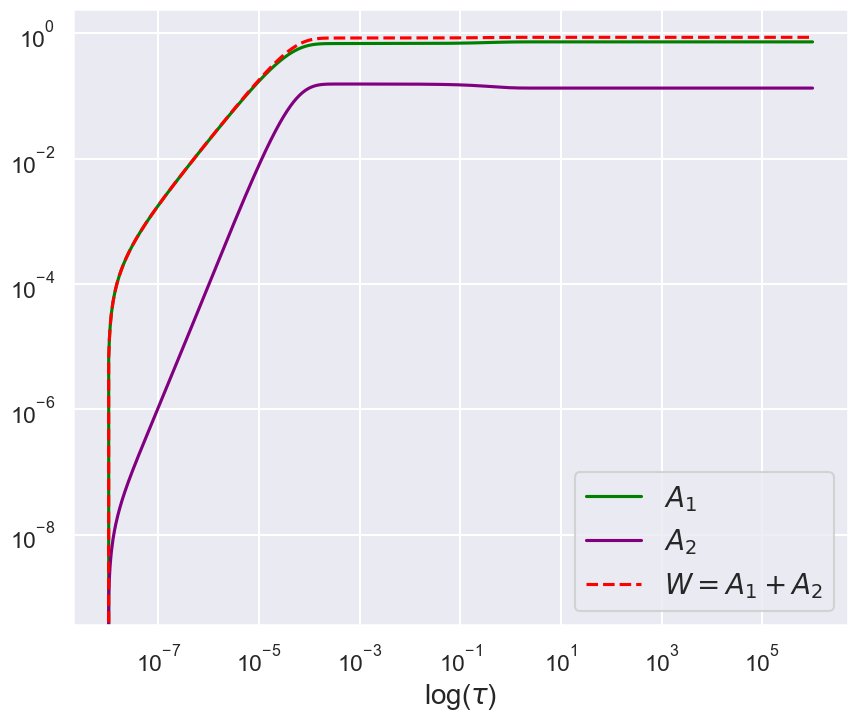

In [3960]:
sns.set_theme()
sns.set_context('talk')
z = solve_ivp(model_S_dimensionless, tspan, z0, method='Radau', t_eval=t, args = (1, 1e4, 1e4))
A1 = z.y[0]
A2 = z.y[1]
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(t, A1, c='green', label=r'$A_1$')
ax.plot(t, (A2), c='purple', label=r'$A_2$')
ax.plot(t, (A1 + A2), c='red', label=r'$W=A_1+A_2$', linestyle='dashed')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='best', fontsize=20)
ax.set_xlabel(r'log($\tau$)', fontsize=20)
#plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/sim_beta_1e-2.png')

Text(0.5, 0, 'log($\\tau$)')

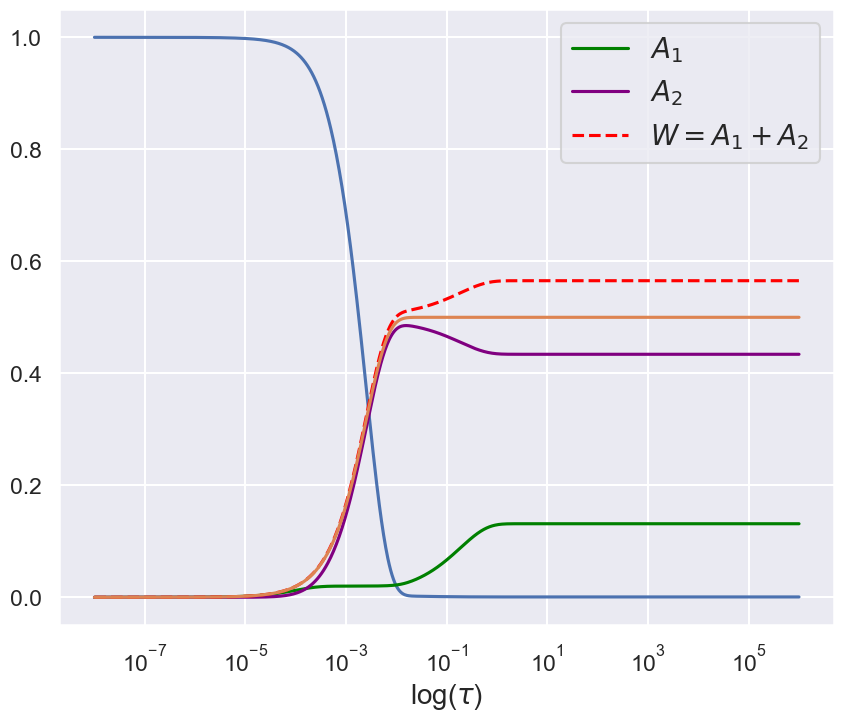

In [3961]:
z = solve_ivp(model_S_dimensionless, tspan, z0, method='Radau', t_eval=t, args = (1, 1e4, 1e2))
A1 = z.y[0]
A2 = z.y[1]
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(t, 1-A1-2*A2)
ax.plot(t, A1, c='green', label=r'$A_1$')
ax.plot(t, (A2), c='purple', label=r'$A_2$')
ax.plot(t, (A1 + A2), c='red', label=r'$W=A_1+A_2$', linestyle='dashed')
ax.plot(t, 0.5*(1 - np.exp(-4*1e2*t)))
ax.set_xscale('log')
ax.legend(loc='best', fontsize=20)
ax.set_xlabel(r'log($\tau$)', fontsize=20)

In [3962]:
well_size*N_A/Target_cell_number

451660557000000.0

In [3963]:
sigma = well_size*N_A/Target_cell_number

def A1_steady_state_1(x, Ainit, k1, koff, k2, rtot):
    k1 = k1/sigma
    Atot = well_size*N_A*Ainit/Target_cell_number
    express = 2*k1*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x))))*(Atot - x - (k2*x*(rtot-x)/(2*(koff + k2*x)))) -koff*x - k2*x*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x)))) +2*koff*(k2*x*(rtot-x)/(2*(koff + k2*x)))

    return express

def A2_steady_state(x, k2, koff, rtot):
    express = k2*x*(rtot-x)/(2*(koff + k2*x))

    return express

def A1_steady_state_dimensionless(x, Ainit, rtot, alpha1, alpha2):
    Atot = sigma*Ainit
    beta = Atot/rtot
    f0 = 2*alpha1*beta
    f1 = alpha1*(2*beta*alpha2 - 2 - 2*alpha2 - 2*beta) -1
    f2 = alpha1*(2 - 2*beta*alpha2) - 2*alpha2
    f3 = alpha1*alpha2 - (alpha2**2)

    return f3*(x**3) + f2*(x**2) + f1*x + f0

def A2_steady_state_dimensionless(A1, alpha2):

    return(alpha2*A1*(1-A1))/(2*(1 + alpha2*A1))


def A1_steady_state(x, Ainit, k1, koff, k2, rtot):
    k1 = k1/sigma
    A2 = k2*x*(rtot-x)/(2*(koff + k2*x))
    Atot = well_size*N_A*Ainit/Target_cell_number
    express = 2*k1*(rtot-x-2*A2)*(Atot-x-A2) - koff*x - k2*(rtot-x-2*A2)*x + 2*koff*A2
    
    return express

def A1_steady_state_try(x, Ainit, kon, koff, k2, rtot):
    k1 = kon/sigma
    Atot = sigma*Ainit
    K1 = k1/koff
    K2 = k2/koff

    f0 = 2*K1*rtot*Atot
    #f1 = -2*K1*(rtot+Atot) -1 +2*K1*K2*rtot*Atot - K1*K2*((rtot)**2)
    f1 = K1*(K2*rtot*(2*Atot-rtot) - (Atot + rtot)) - 1
    f2 = 3*K1 - 3*K2 - 2*K1*K2*Atot 
    f3 = K1*K2 - (K2**2) 

    express = (f3*(x**3) + f2*(x**2) + f1*x + f0)
    return express

"""
def A1_steady_state(x, Ainit, k1, koff, k2, rtot):
    k1 = k1/sigma
    Atot = well_size*N_A*Ainit/Target_cell_number
    f0 = 2*k1*(koff**2)*rtot*Atot
    f1 = -2*k1*(koff**2)*(rtot+Atot) + k1*k2*koff*rtot*(2*Atot-rtot) + k1*k2*rtot + (koff**2)*(2*k1*rtot*Atot - koff)
    f2 = k1*(2*(koff**2) - 2*k2*koff*(rtot+Atot) + rtot*(koff - (k2**2)*rtot) - k2)
    f3 = (k2*koff)*(2*k1 - k2)
    f4 = (k2**2)*(k1 + 1 -k2)
    express = f4*(x**4) + f3*(x**3) + f2*(x**2) + f1*x + f0
    return express
"""


'\ndef A1_steady_state(x, Ainit, k1, koff, k2, rtot):\n    k1 = k1/sigma\n    Atot = well_size*N_A*Ainit/Target_cell_number\n    f0 = 2*k1*(koff**2)*rtot*Atot\n    f1 = -2*k1*(koff**2)*(rtot+Atot) + k1*k2*koff*rtot*(2*Atot-rtot) + k1*k2*rtot + (koff**2)*(2*k1*rtot*Atot - koff)\n    f2 = k1*(2*(koff**2) - 2*k2*koff*(rtot+Atot) + rtot*(koff - (k2**2)*rtot) - k2)\n    f3 = (k2*koff)*(2*k1 - k2)\n    f4 = (k2**2)*(k1 + 1 -k2)\n    express = f4*(x**4) + f3*(x**3) + f2*(x**2) + f1*x + f0\n    return express\n'

In [3964]:
print(1e5/sigma)

2.214052089565129e-10


In [3965]:
A0s = np.geomspace(1e-12, 1e-5, 100)

A1_st_sim = np.zeros_like(A0s)
A1_st_root = np.zeros_like(A0s)
A2_st_sim = np.zeros_like(A0s)
A2_st_root = np.zeros_like(A0s)

A1_st_sim_1 = np.zeros_like(A0s)
A1_st_root_1 = np.zeros_like(A0s)
A2_st_sim_1 = np.zeros_like(A0s)
A2_st_root_1 = np.zeros_like(A0s)

D = 1e-14
k2 = 4*D/tumour_cell_surface_area
rtot = 1e4
kon = 1e5
koff = 1e-4
alpha1 = kon*rtot/(koff*sigma)
alpha2 = k2*rtot/koff


for i, Ainit in enumerate(A0s):
    Atot = sigma*Ainit
    beta =Atot/rtot
    """
    A1_st_root[i] = fsolve(A1_steady_state_dimensionless, [1], args=(Ainit, rtot, alpha1, alpha2))
    A2_st_root[i] = A2_steady_state_dimensionless(A1_st_root[i], alpha2)
    """
    
    A1_st_root[i] = fsolve(A1_steady_state_try, [100000], args=(Ainit, kon, koff, k2, rtot))
    A2_st_root[i] = A2_steady_state(A1_st_root[i], k2, koff, rtot)
    
    #z = solve_ivp(model_S_dimensionless, tspan, z0, method='Radau', t_eval=t, args=(alpha1, alpha2, beta))
    z = solve_ivp(model_S_monospecific, tspan, z0, method='Radau', t_eval=t, args=(Ainit, rtot, kon, k2, koff))
    A1 = z.y[0]
    A2 = z.y[1]
    A1_st_sim[i] = A1[-1]/(A1[-1] + A2[-1])
    A2_st_sim[i] = A2[-1]/(A1[-1] + A2[-1])

rtot = 1e6 

for i, Ainit in enumerate(A0s):
    Atot = sigma*Ainit
    beta =Atot/rtot
    """
    A1_st_root[i] = fsolve(A1_steady_state_dimensionless, [1], args=(Ainit, rtot, alpha1, alpha2))
    A2_st_root[i] = A2_steady_state_dimensionless(A1_st_root[i], alpha2)
    """
    
    A1_st_root_1[i] = fsolve(A1_steady_state_try, [100000], args=(Ainit, kon, koff, k2, rtot))
    A2_st_root_1[i] = A2_steady_state(A1_st_root[i], k2, koff, rtot)
    
    #z = solve_ivp(model_S_dimensionless, tspan, z0, method='Radau', t_eval=t, args=(alpha1, alpha2, beta))
    z = solve_ivp(model_S_monospecific, tspan, z0, method='Radau', t_eval=t, args=(Ainit, rtot, kon, k2, koff))
    A1 = z.y[0]
    A2 = z.y[1]
    A1_st_sim_1[i] = A1[-1]/(A1[-1] + A2[-1])
    A2_st_sim_1[i] = A2[-1]/(A1[-1] + A2[-1])


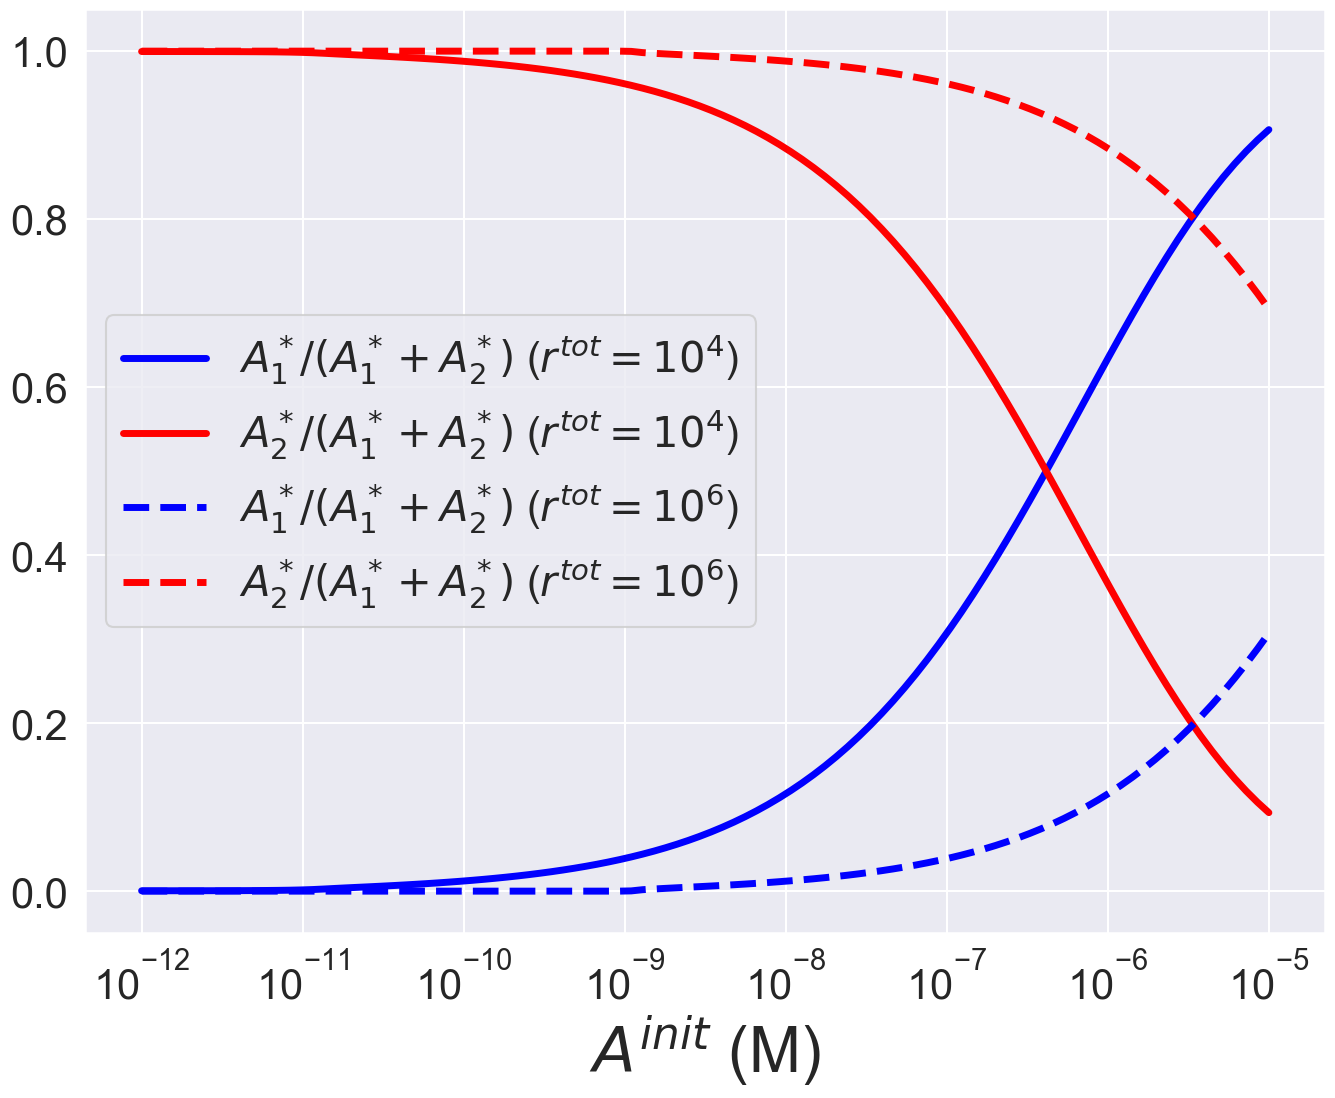

In [3966]:
sns.set_theme()
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(16, 12))
ax.plot(A0s, A1_st_sim, label = r'$A_1^*/(A_1^* + A_2^*)$ ($ r^{{tot}} = 10^4$)', color='blue', lw=5)
ax.plot(A0s, A2_st_sim, label = r'$A_2^*/(A_1^* + A_2^*)$ ($ r^{{tot}} = 10^4$)', color='red', lw=5)
ax.plot(A0s, A1_st_sim_1, label = r'$A_1^*/(A_1^* + A_2^*)$ ($ r^{{tot}} = 10^6$)', color='blue', linestyle ='dashed', lw=5)
ax.plot(A0s, A2_st_sim_1, label = r'$A_2^*/(A_1^* + A_2^*)$ ($ r^{{tot}} = 10^6$)', color='red', linestyle='dashed', lw=5)
#plt.plot(A0s, A2_st_root, label = 'A2 calculated root')
ax.tick_params(axis='both', which='major', labelsize=30)
#plt.title('Model S Equilibrium Binding States')
ax.set_xscale('log')
ax.legend(loc='best', fontsize=30)
ax.set_xlabel(r'$A^{init}$ (M)', fontsize=45)
plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/stst_rtot_1e6+1e4.png', dpi=400)

0.2214052089565129


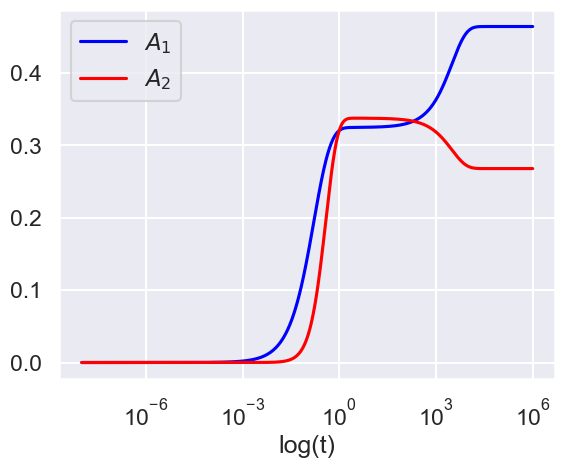

In [3967]:
print((1e5/sigma)*1e5/1e-4)
z = solve_ivp(model_S_monospecific, tspan, z0, method='Radau', t_eval=t, args=(1e-5, 1e5, 1e5, k2, 1e-4))
plt.plot(t, z.y[0]/1e5, label=r'$A_1$', c='blue')
plt.plot(t, z.y[1]/1e5, label = r'$A_2$', c='red')
plt.legend(loc='best')
plt.xlabel('log(t)')
plt.xscale('log')
plt.show()

In [3968]:
print(1e-5*sigma/1e5)

45166.0557


In [3969]:
def A2_nullcline1(A2, alpha2):
    a = 1
    b = 2*A2 -1 
    c = (2/alpha2)
    express = (-b + np.sqrt((b)**2 - 4*a*c))/(2*a)

    return express

def A2_nullcline2(A2, alpha2):
    a = 1
    b = 2*A2 -1 
    c = (2/alpha2)
    express = (-b - np.sqrt((b)**2 - 4*a*c))/(2*a)

    return express

def A1_nullcline1(A2, alpha1, alpha2, beta):
    a = (2*alpha1 + alpha2)
    b = (2*alpha1)*(3*A2 - beta - 1)  -1 -alpha2*(1+2*A2)
    c = 2*alpha1*(beta*(1- 2*A2) - A2 + 2*((A2)**2)) + 2*A2
    express = (-b - np.sqrt((b)**2 - 4*a*c))/(2*a)

    return express

def A1_nullcline2(A2, alpha1, alpha2, beta):
    a = (2*alpha1 + alpha2)
    b = (2*alpha1)*(3*A2 - beta - 1)  -1 -alpha2*(1+2*A2)
    c = 2*alpha1*(beta*(1- 2*A2) - A2 + 2*((A2)**2)) + 2*A2
    express = (-b + np.sqrt((b)**2 - 4*a*c))/(2*a)

    return express



In [3970]:
def A2_nullcline(x, alpha2):

    return (alpha2*x*(1-x))/(2*(1+ x*alpha2))

def A1_nullcline1(A1, alpha1, alpha2, beta):
    a = (4*alpha1)
    b = (2*alpha1)*(3*A1 - 2*beta - 1)  + 2 + 2*alpha2*A1
    c = 2*alpha1*(beta - A1 - A1*beta + ((A1)**2)) - A1 -alpha2*A1*(1-A1)
    express = (-b - np.sqrt((b)**2 - 4*a*c))/(2*a)

    return express

def A1_nullcline2(A1, alpha1, alpha2, beta):
    a = (4*alpha1)
    b = (2*alpha1)*(3*A1 - 2*beta - 1)  + 2 + 2*alpha2*A1
    c = 2*alpha1*(beta - A1 - A1*beta + ((A1)**2)) - A1 -alpha2*A1*(1-A1)
    express = (-b + np.sqrt((b)**2 - 4*a*c))/(2*a)

    return express

0.2214052089565129
4973.5919716217295
451.66055700000004


/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_62174/4036392180.py:9: RuntimeWarning: invalid value encountered in sqrt
  express = (-b - np.sqrt((b)**2 - 4*a*c))/(2*a)
/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_62174/4036392180.py:17: RuntimeWarning: invalid value encountered in sqrt
  express = (-b + np.sqrt((b)**2 - 4*a*c))/(2*a)


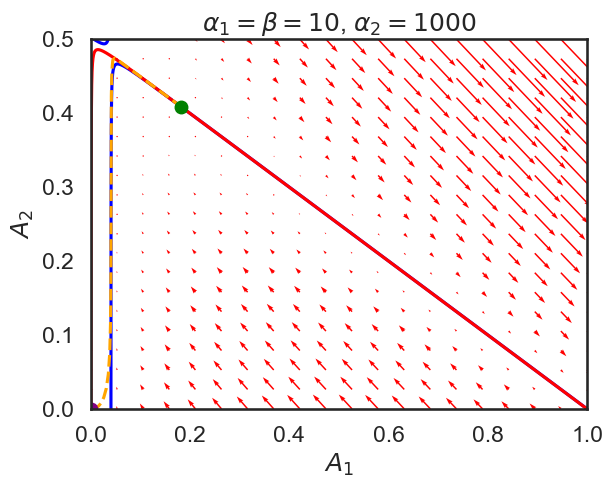

In [3971]:
sns.set_theme(style = "white")
sns.set_context("talk")

kon = 1e5
rtot = 1e5
x1 = np.linspace(0, 1, 50000)
x2 = np.linspace(0, 1/2, 500)
D = 1e-15
k2 = 4*D/tumour_cell_surface_area
koff = 1e-4
Ainit = 1e-7
Atot = well_size*N_A*Ainit/Target_cell_number
t_end = 60*60*10*1000000000
t = np.geomspace(1e-10, t_end, 150)
tspan = [1e-10, t_end]

sigma = well_size*N_A/Target_cell_number
alpha1 = kon*rtot/(sigma*koff)
print(alpha1)
alpha2 = k2*rtot/koff
print(alpha2)
beta = Atot/rtot
print(beta)
#alpha1 = 100
#alpha2 = 10
#beta = 100

t1 = 0

z = solve_ivp(model_S_dimensionless, tspan, z0, method='Radau', t_eval=t, args=(alpha1, alpha2, beta))
y1 = np.linspace(0, 1, 20)
y2 = np.linspace(0, 0.5, 20)

Y1, Y2 = np.meshgrid(y1, y2)

A1, A2 = np.zeros(Y1.shape), np.zeros(Y2.shape)

Ni, Nj = Y1.shape

for i in range(Ni):
    for j in range(Nj):
        x = Y1[i, j]
        y = Y2[i, j]
        yprime = model_S_dimensionless(t1, [x, y], alpha1, alpha2, beta)
        A1[i, j] = yprime[0]
        A2[i, j] = yprime[1]

plt.plot(x1, A1_nullcline1(x1, alpha1, alpha2, beta),  c='blue', label='A1 nullcline')
plt.plot(x1, A1_nullcline2(x1, alpha1, alpha2, beta), c= 'blue')#, label='null 3')
plt.plot(x1, A2_nullcline(x1, alpha2),  c='red', label='A1 nullcline')
Q = plt.quiver(Y1, Y2, A1, A2, color='red')
z1 = z.y[0]
z2 = z.y[1]
plt.plot(z1, z2, '--', label='trajectory', c='orange')
plt.plot([z1[0]], [z2[0]], 'o', c = 'purple',label='initial condition')
plt.plot([z1[-1]], [z2[-1]], 'o', c='green', label='equilibrium')

#f = A2_steady_state(x1, alpha2)
#g = A2_alternative_null_minus(x2, alpha1, alpha2, beta)



#plt.legend(loc='best')


plt.xlim(0, 1)
plt.ylim(0, 0.5)
plt.xlabel(r'$A_1$')
plt.title(r'$\alpha_1 = \beta = 10$' + r', $\alpha_2=1000$')
plt.ylabel(r'$A_2$')
#sns.despine()
plt.show()


In [3972]:
A0s = np.geomspace(1e-12, 1e-5, 300)
alpha1s = np.geomspace(1e-3, 1e2, 300)
alpha2s = np.geomspace(1e2, 1e7, 300)
k1s = np.geomspace(1e4, 1e6, 50)
r_abs = np.linspace(1e-9, 5e-9, 300)
rtots = np.geomspace(1e4, 1e6, 300)
rtot = 1e5
kon = 1e5
koff = 1e-4
sigma = well_size*N_A/Target_cell_number

r_ab = 1.25e-8
r_cell = 8e-6
Target_cell_number = 2e5
reaction_volume = (2*math.pi/3)*(r_ab**3)
Ageff = (1/reaction_volume)*(rtot/N_A)*((4*math.pi*r_ab)**2)
assay_volume = 150e-6
D = 1e-14
k2 = 4*D/tumour_cell_surface_area
alpha1 = kon*rtot/(sigma*koff)
#k2 = kon*Ageff
kon_powers = np.linspace(5, 3, 300)
koff_powers = np.linspace(-5, -3, 300)
D_powers = np.linspace(-15, -13, 300)
Ds = 10**D_powers
rtots = np.flip(np.linspace(4, 6, 300))
rtots = 10**rtots
kons = 10**kon_powers
koffs = 10**koff_powers
Ainit= 1e-5
rtot=1e5
Y = np.zeros((len(alpha1s), len(alpha2s)))
Y1 = np.zeros((len(alpha1s), len(alpha2s)))

for i, rtot in enumerate(rtots):
    for j, Ainit in enumerate(A0s):
        alpha1 = kon*rtot/(sigma*koff)
        alpha2 = k2*rtot/koff
        A1 = fsolve(A1_steady_state_dimensionless, [1], args=(Ainit, rtot, alpha1, alpha2))
        A2 = A2_steady_state_dimensionless(A1, alpha2)
        Y[i, j] =  A2/(A1 + A2)


<AxesSubplot:>

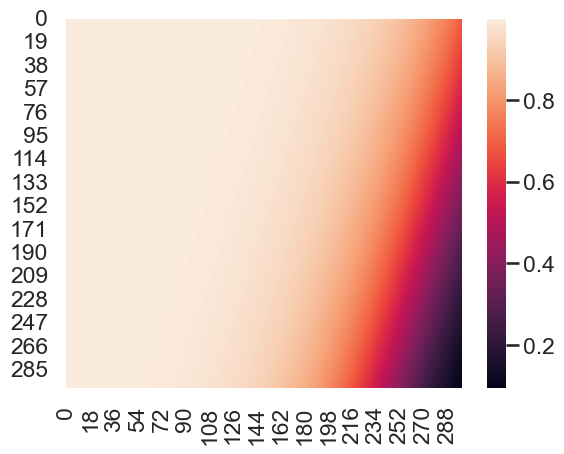

In [3973]:
sns.heatmap(Y)

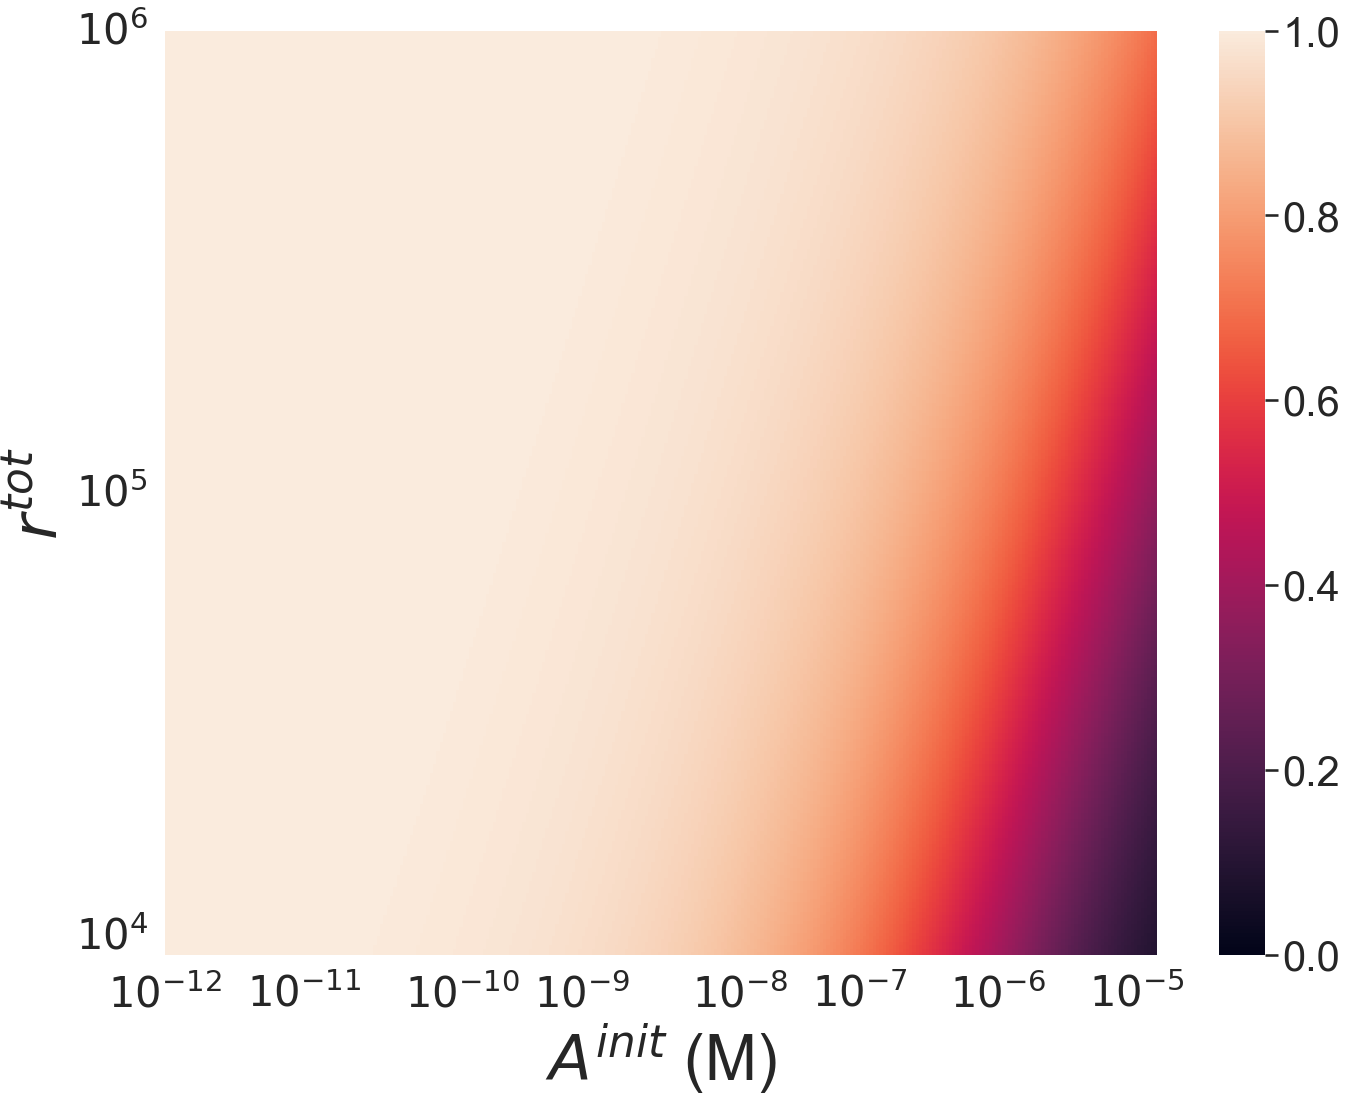

In [3974]:
fig, ax = plt.subplots(figsize=(16, 12))
line = sns.heatmap(Y, xticklabels=True, yticklabels=True, ax=ax, vmin=0, vmax=1) 
#ax = sns.heatmap(Y[0,:,:], xticklabels=True, yticklabels=True, ax=ax)
ax.set_xticks([0, 7*6, 15*6, 21*6, 29*6, 35*6, 42*6, 49*6])
ax.set_yticks([0, 25*6, 49*6])
#ax.set_xticks([0, 9*6, 20*6, 32*6, 49*6])
#ax.set_yticklabels([10, r'$10^2$', r'$10^3$', r'$10^4$', r'$10^5$'])
ax.set_yticklabels([r'$10^{6}$', r'$10^{5}$', r'$10^{4}$'], fontsize=30)
#ax.set_yticklabels([r'$10^{-10}$', r'$10^{-9}$',r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$'], fontsize=30)
ax.set_xticklabels([r'$10^{-12}$', r'$10^{-11}$', r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$'], fontsize=30, rotation=360)
ax.set_xlabel(r'$A^{init}$ (M)', fontsize=45)
ax.set_ylabel(r'$r^{tot}$', fontsize=45)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)
#plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/S_A2_frac_heatmap.png', dpi=400)